---
# **Road Image Segmentation on the KITTI Road Dataset**
---

**Imports**

In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
import torchmetrics
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms.functional as TF
from torchvision import models
from collections import defaultdict
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from PIL import Image
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, jaccard_score, confusion_matrix, precision_score, recall_score

**Directories**

In [2]:
img_path = '/DML/Datasets/KITTI_ROAD/training/image_2/'
mask_path = '/DML/Datasets/KITTI_ROAD/training/gt_image_2/'
test_path = '/DML/Datasets/KITTI_ROAD/testing/'

**Pre-processing**

    1) We are splitting the input images into three sets: Training Data (70%), Validation Data (15%) and Test Data (15%).
    2) Create a function to Load, Sort, Resize, and Convert Images into a Numpy Array
    3) Create a function to view/display images and masks
    4) Create a function to convert the true mask into a binary mask (Road == 1; Non-road == 0)
    5) Convert the binary mask to grayscale and normalize it
    

Number of Training Images: 202
Number of Validation Images: 43
Number of Testing Images: 44
['um_000000.png', 'um_000001.png', 'um_000002.png', 'um_000003.png', 'um_000004.png', 'um_000005.png', 'um_000006.png', 'um_000007.png', 'um_000008.png', 'um_000009.png', 'um_000010.png', 'um_000011.png', 'um_000012.png', 'um_000013.png', 'um_000014.png', 'um_000015.png', 'um_000016.png', 'um_000017.png', 'um_000018.png', 'um_000019.png', 'um_000020.png', 'um_000021.png', 'um_000022.png', 'um_000023.png', 'um_000024.png', 'um_000025.png', 'um_000026.png', 'um_000027.png', 'um_000028.png', 'um_000029.png', 'um_000030.png', 'um_000031.png', 'um_000032.png', 'um_000033.png', 'um_000034.png', 'um_000035.png', 'um_000036.png', 'um_000037.png', 'um_000038.png', 'um_000039.png', 'um_000040.png', 'um_000041.png', 'um_000042.png', 'um_000043.png', 'um_000044.png', 'um_000045.png', 'um_000046.png', 'um_000047.png', 'um_000048.png', 'um_000049.png', 'um_000050.png', 'um_000051.png', 'um_000052.png', 'um_00

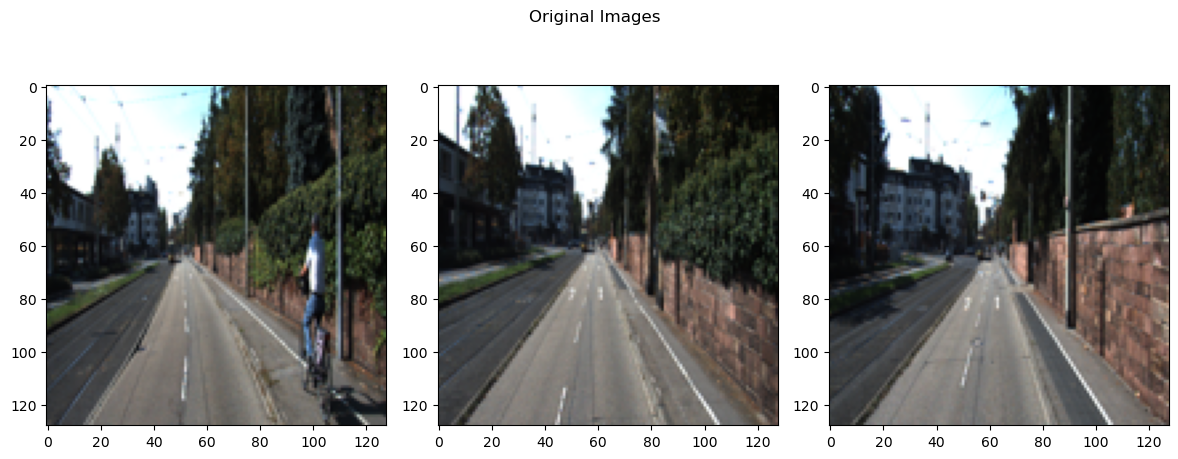

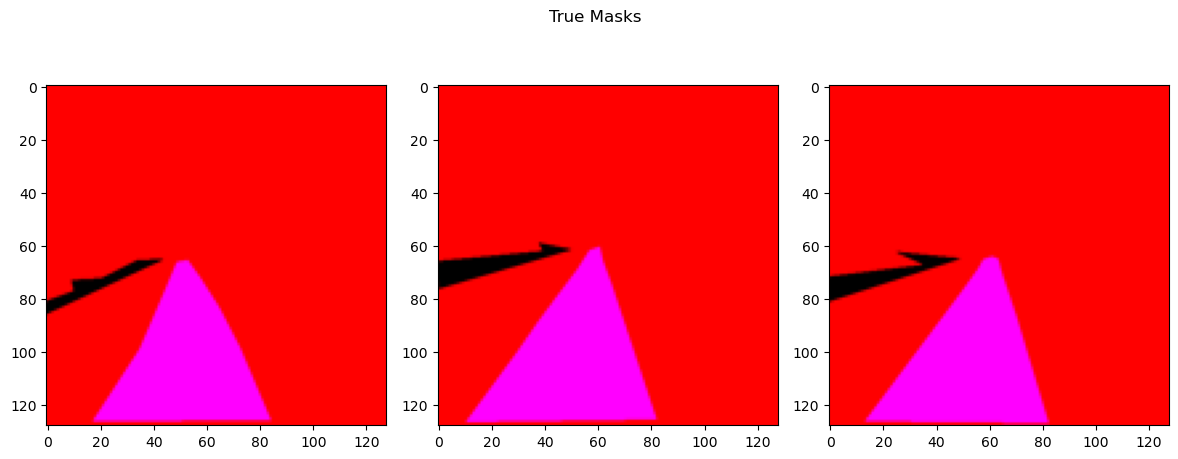

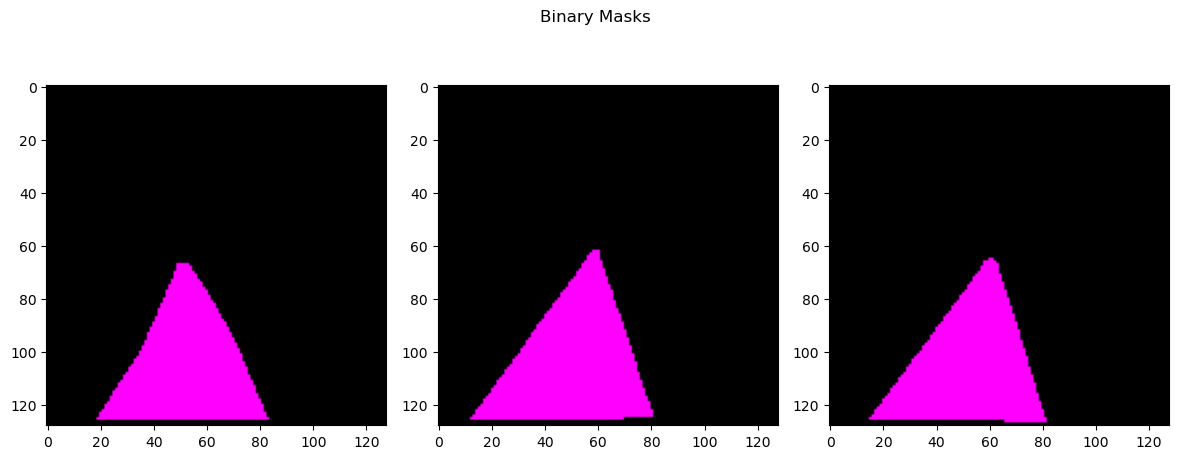

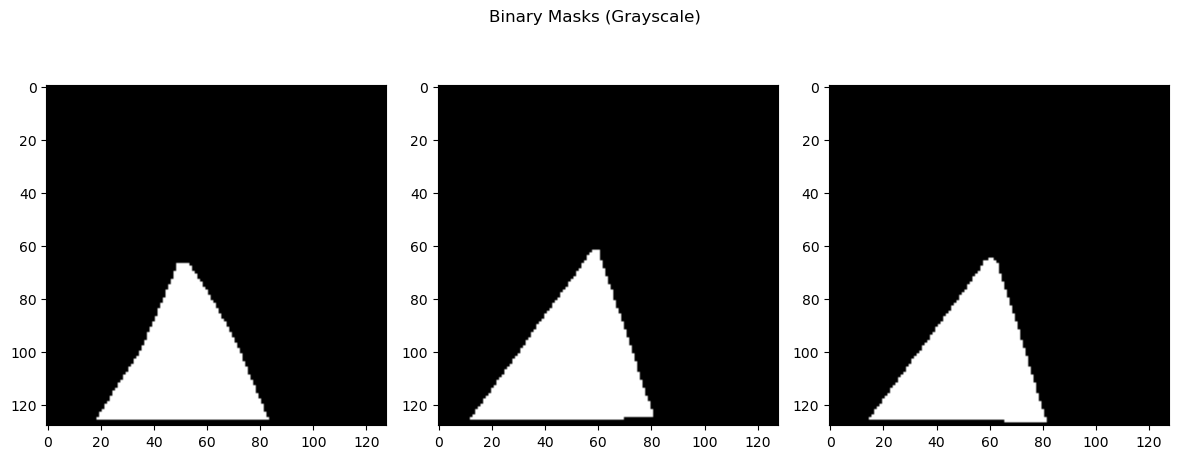

In [3]:
# Manual Train/Val/Test Split
train_size = int(len(os.listdir(img_path)) * 0.70)
val_size = int(len(os.listdir(img_path)) * 0.15)
test_size = int(len(os.listdir(img_path)) - train_size - val_size)
img_size = (128, 128) # For UNet Model
# img_size = (224, 224) # For Modified VGG Model

# Printing respective sizes
print(f"Number of Training Images: {train_size}")
print(f"Number of Validation Images: {val_size}")
print(f"Number of Testing Images: {test_size}")

# Load, Sort, Resize Images into a Numpy Array
def ProcessImages(path, mask=False):
    result = [] 
    images = os.listdir(path)
    if mask == True:
        images = [entry for entry in images if "road" in entry]
    images=sorted(images)
    print(images)
    for image in images:
        im = Image.open(os.path.join(path, image))
        resized_image = im.resize(img_size)
        res = np.asarray(resized_image)
        result.append(res)
    return np.array(result)

# Display the Images
def DisplayImages(images, disp_count, title, is_mask=False, is_grayscale=False):
    fig = plt.figure(figsize=(12, 5))
    plt.suptitle(title)
    for i in range(1, disp_count+1):
        fig.add_subplot(1, disp_count, i)
        img = images[i-1, :]
        cmap = 'gray' if is_mask or is_grayscale else None
        plt.tight_layout()
        plt.imshow(img, cmap=cmap)

# Convert the Images and Masks into Numpy Arrays
true_images = ProcessImages(img_path, mask=False)
true_masks = ProcessImages(mask_path, mask=True)

# Display the Images and its respective Masks
DisplayImages(true_images, 3, 'Original Images')
DisplayImages(true_masks, 3, 'True Masks')

# Convert the true mask into a binary mask (Road == 1; Non-road == 0)
def encode_binary(true_masks):
    for i in range(len(true_masks)):
        road_label = np.array([255, 0, 255])
        binary_mask = np.all(true_masks[i] == road_label, axis = 2)
        true_masks[i] = true_masks[i] * binary_mask[..., np.newaxis]

# Display the respective Binary Encoded Masks 
encode_binary(true_masks)
DisplayImages(true_masks, 3, 'Binary Masks', is_mask=True)

# Grayscale Binary Masks
true_masks = np.dot(true_masks[..., :3], [0.2989, 0.5870, 0.1140]) 
true_masks = np.expand_dims(true_masks, axis=-1)
DisplayImages(true_masks, 3, 'Binary Masks (Grayscale)', is_grayscale=True)

# Normalize the Grayscale Binary Masks
true_masks[true_masks != 0.0] = 1.0
true_images  = true_images / 255.0

# Verify the shape
print(f"Shape of the Image: {true_images.shape}")
print(f"Shape of the Label/Mask: {true_masks.shape}")
true_images = true_images.astype(np.float32)
true_masks = true_masks.astype(np.float32)

**Splitting the Data**

In [4]:
# Testing Dataset
X_test = true_images[:test_size].transpose((0, 3, 1, 2))
Y_test = true_masks[:test_size].transpose((0, 3, 1, 2))

# Training and Validation Dataset
true_images = true_images[test_size:]
true_masks = true_masks[test_size:]
idx = np.random.permutation(len(true_images))  # Shuffle = True
shuffled_images = true_images[idx]
shuffled_masks = true_masks[idx]

# Train/Val Split
X_train=shuffled_images[:train_size].transpose((0, 3, 1, 2))
Y_train=shuffled_masks[:train_size].transpose((0, 3, 1, 2))
X_val=shuffled_images[train_size:train_size+val_size].transpose((0, 3, 1, 2))
Y_val=shuffled_masks[train_size:train_size+val_size].transpose((0, 3, 1, 2))

# Printing the shape of the Datasets
print(f'Training Dataset Shape: {X_train.shape}')
print(f'Validation Dataset Shape: {X_val.shape}')
print(f'Testing Dataset Shape: {X_test.shape}')

Training Dataset Shape: (202, 3, 128, 128)
Validation Dataset Shape: (43, 3, 128, 128)
Testing Dataset Shape: (44, 3, 128, 128)


**Dataset Class**

In [5]:
class SegmentDataset(Dataset):
    def __init__(self, imgs,mask):
        self.imgs = imgs
        self.mask = mask

    def __len__(self):
        return len(self.imgs)

    def get_batch_imgs(self, idx):
        return self.imgs[idx]
    
    def get_batch_masks(self, idx):
        return self.mask[idx]
    
    def __getitem__(self, index):
        imgs = self.get_batch_imgs(index)
        masks = self.get_batch_masks(index)
        return imgs,masks

**Data Loading**

In [6]:
# Datasets
train_dataset = SegmentDataset(X_train, Y_train)
val_dataset = SegmentDataset(X_val, Y_val)
test_dataset = SegmentDataset(X_test, Y_test)

# Initialize Parameters
batch_size = 16

# Dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

**UNet Model**

In [7]:
# NOTE: derived from Andrew Ng's Deep Learning Class
# Double Convolution Class
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv,self).__init__()
        self.dconv = nn.Sequential(nn.Conv2d(in_channels,out_channels,kernel_size=3,stride=1,padding=1,bias=False),
                                   nn.BatchNorm2d(out_channels),
                                   nn.ReLU(inplace=True),
                                   nn.Conv2d(out_channels,out_channels,kernel_size=3,stride=1,padding=1,bias=False),
                                   nn.BatchNorm2d(out_channels),
                                   nn.ReLU(inplace=True),
        )
        
    def forward(self, x):
        return self.dconv(x)
    
# Our UNet Model Class 
in_features = 3
out_features = 1

class UNET(nn.Module):
    def __init__(self, in_channels=in_features, out_channels=out_features, features=[64, 128, 256, 512]):
        super(UNET,self).__init__()
        
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)) # Upsampling
            self.ups.append(DoubleConv(feature*2, feature))

        self.left_over = DoubleConv(features[-1], features[-1]*2) # last part which starts the UP phase
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1) # output segmentation  map

    def forward(self,x):
        skip_connections = []
        
        # Start Down Phase
        for layer in self.downs:
            x=layer(x)
            skip_connections.append(x) 
            x=self.pool(x)
        
        # Pass through (Left-to-Right))
        x=self.left_over(x)
        skip_connections=skip_connections[::-1]

        # Feeding to transposed conv (add skipped connection - 2 steps)
        for idx in range(0,len(self.ups), 2): 
            
            sc=skip_connections[idx//2]
            x=self.ups[idx](x)
            
            if x.shape != sc.shape:
                x = TF.resize(x, size=sc.shape[2:])

            concat_skip = torch.cat((sc, x), dim=1)  
            x = self.ups[idx+1](concat_skip) 

        return self.final_conv(x)   # No sigmoid here; return logits directly
    
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {DEVICE}")
print(f"Network Architecture Used:\n {UNET()}")

Device: cpu
Network Architecture Used:
 UNET(
  (ups): ModuleList(
    (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
    (1): DoubleConv(
      (dconv): Sequential(
        (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (3): DoubleConv(
      (dconv): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(256,

**VGGNet Model**

In [8]:
# # Define FCN network using VGG-16 as backbone
# class Modified_VGG(nn.Module):
#     def __init__(self, num_classes):
#         super(Modified_VGG, self).__init__()
#         # vgg = models.vgg16(pretrained=True)
#         vgg = models.vgg16()
#         vgg.load_state_dict(torch.load("/DML/vgg16-397923af.pth"))
#         self.features = vgg.features
        
#         # Decoder
#         self.upconv1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
#         self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
#         self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=8, stride=8)
        
#         # Final segmentation layer
#         self.classifier = nn.Conv2d(64, num_classes, kernel_size=1)

#     def forward(self, x):
#         x = self.features(x)
        
#         # Upsampling path
#         x = self.upconv1(x)
#         x = self.upconv2(x)
#         x = self.upconv3(x)
        
#         return self.classifier(x)   # No activation (e.g., sigmoid) here since we will use BCEWithLogitsLoss
    
class Modified_VGG(nn.Module):
    def __init__(self):
        super(Modified_VGG, self).__init__()
        
        # Load pretrained VGG16 and extract the convolutional layers (encoder)
        vgg16 = models.vgg16()
        vgg16.load_state_dict(torch.load("/DML/vgg16-397923af.pth"))
        self.encoder = vgg16.features
        
        # Define decoder layers (upsampling)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),  # Upconv 1 (from 32x32 -> 64x64)
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),  # Upconv 2 (from 64x64 -> 128x128)
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),   # Upconv 3 (from 128x128 -> 256x256)
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, kernel_size=1),                        # Final output (binary map)
            nn.Upsample(size=(512, 512), mode='bilinear', align_corners=True)  # Resize to 512x512
        )
    
    def forward(self, x):
        # Encode using VGG16 (backbone)
        x = self.encoder(x)
        
        # Decode to produce segmentation map
        x = self.decoder(x)
        
        # No activation (e.g., sigmoid) here since we will use BCEWithLogitsLoss
        return x
    
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {DEVICE}")
print(f"Network Architecture Used:\n {Modified_VGG()}")

Device: cpu
Network Architecture Used:
 Modified_VGG(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2

**Initialize the Evaluation Metrics**

In [9]:
f1_metric = torchmetrics.F1Score(task="binary", num_classes=1, threshold=0.5).to(DEVICE)
iou_metric = torchmetrics.JaccardIndex(num_classes=1, task="binary").to(DEVICE)
accuracy_metric = torchmetrics.Accuracy(task="binary", threshold=0.5).to(DEVICE)

**Loss Calculation based on IoU Metric**

In [10]:
# class IoU_Loss(nn.Module):
#     def __init__(self, smooth=1e-6):
#         super(IoU_Loss, self).__init__()
#         self.smooth = smooth

#     def forward(self, pred, target):
#         pred = torch.sigmoid(pred)
#         intersection = (pred * target).sum(dim=(2, 3))
#         union = (pred + target).sum(dim=(2, 3)) - intersection

#         # Calculate IoU Score and IoU Loss
#         iou = (intersection + self.smooth) / (union + self.smooth)
#         mIoU = iou.mean()    # IoU Score
#         iou_loss = 1 - mIoU  # IoU Loss

#         return iou_loss

**IoU Score Calculation**

In [11]:
# def iou_score(pred, target, smooth=1e-6):
#     pred = torch.sigmoid(pred)
#     intersection = (pred * target).sum(dim=(2, 3))
#     union = (pred + target).sum(dim=(2, 3)) - intersection
#     iou = (intersection + smooth) / (union + smooth)
#     return iou.mean().item()

**Calculating weights for classes (based on the training masks)**

In [ ]:
def calculate_class_weights(train_dataset):
    total_pixels = 0
    foreground_pixels = 0

    for _, train_mask in train_dataset:
        # Convert numpy array to torch tensor if it's not already a tensor
        train_mask = torch.tensor(train_mask) if isinstance(train_mask, np.ndarray) else train_mask

        total_pixels += train_mask.numel()
        foreground_pixels += (train_mask == 1).sum().item()

    background_pixels = total_pixels - foreground_pixels

    # Class weights: inverse of frequency
    weight_foreground = total_pixels / (2 * foreground_pixels)
    weight_background = total_pixels / (2 * background_pixels)

    return torch.tensor([weight_background, weight_foreground], dtype=torch.float32)

class_weights = calculate_class_weights(train_dataset).to(DEVICE)
print(f"Class Weights: Non-Road: {class_weights[0]}, Road: {class_weights[1]}")




In [ ]:
# Function to calculate the class weights based on pixel distribution
def calculate_class_weights(mask_dataloader):
    total_pixels = 0
    road_pixels = 0

    for _, mask in mask_dataloader:
        total_pixels += mask.numel()  # Total number of pixels in the dataset
        road_pixels += (mask == 1).sum().item()  # Count of "road" pixels (value 1)

    non_road_pixels = total_pixels - road_pixels  # Count of "non-road" pixels (value 0)

    # Calculate weights inversely proportional to class frequency
    road_weight = non_road_pixels / total_pixels
    non_road_weight = road_pixels / total_pixels

    return torch.tensor([non_road_weight, road_weight]).to(DEVICE)

# Example: Calculate weights using the training data
class_weights = calculate_class_weights(train_dataloader)
print(f"Class Weights: Non-Road: {class_weights[0]}, Road: {class_weights[1]}")

**Dice Coefficient Function**

In [12]:
def dice_coefficient(pred, target, smooth=1e-6):
    pred = pred.contiguous()
    target = target.contiguous()
    # Intersection over all pixels
    intersection = (pred * target).sum(dim=2).sum(dim=2)  
    dice = (2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)
    return dice.mean()

**Precision, Recall and F1-Score Calculation**

In [13]:
# def precision_recall_f1(pred, target, smooth=1e-6):
#     pred = torch.sigmoid(pred) > 0.5  # Binary classification threshold
#     pred = pred.contiguous().view(-1)
#     target = target > 0.5  # Ensure target is boolean
#     target = target.contiguous().view(-1)

#     true_positive = (pred * target).sum().float()
#     false_positive = (pred * (~target)).sum().float()
#     false_negative = ((~pred) * target).sum().float()

#     precision = (true_positive + smooth) / (true_positive + false_positive + smooth)
#     recall = (true_positive + smooth) / (true_positive + false_negative + smooth)
#     f1_score = 2 * (precision * recall) / (precision + recall + smooth)

#     return precision.item(), recall.item(), f1_score.item()


**Training and Validation Loop**

In [14]:
# Training Loop
def train_epoch(model, data_loader, loss_fn, optimizer, device):
    model.train()
    losses = []
    dice_scores = []

    for train_input, train_mask in data_loader:
        train_mask = train_mask.to(device)
        train_input = train_input.to(device)
        
        # Forward pass
        outputs = model(train_input.float())

        # Compute loss without applying sigmoid
        loss = loss_fn(outputs, train_mask.float())   # outputs are typically a torch.FloatTensor
        losses.append(loss.item())

        # Back-prop
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Calculate Dice score using sigmoid applied to outputs
        outputs = torch.sigmoid(outputs)
        dice = dice_coefficient(outputs, train_mask)
        dice_scores.append(dice.item())

    return np.mean(losses), np.mean(dice_scores)

# Validation Loop
def validate_model(model, data_loader, loss_fn, device):
    model.eval()
    losses = []
    dice_scores = []
    f1_scores = []
    iou_scores = []
    accuracies = []

    with torch.no_grad():
        for val_input, val_mask in data_loader:
            val_input = val_input.to(device)
            val_mask = val_mask.to(device)
            
            # Forward pass
            outputs = model(val_input.float())

            # Compute loss without applying sigmoid
            loss = loss_fn(outputs, val_mask.float())   # outputs are typically a torch.FloatTensor
            losses.append(loss.item())

            # Calculate Dice score using sigmoid applied to outputs
            outputs = torch.sigmoid(outputs)
            dice = dice_coefficient(outputs, val_mask)
            dice_scores.append(dice.item())

            # Compute IoU, F1-Score, and Accuracy using torchmetrics
            f1 = f1_metric(outputs, val_mask).item()
            iou = iou_metric(outputs, val_mask).item()
            accuracy = accuracy_metric(outputs, val_mask).item()

            # Append the outputs
            f1_scores.append(f1)
            iou_scores.append(iou)
            accuracies.append(accuracy)
    
    return {"val_loss": np.mean(losses), "val_dice": np.mean(dice_scores), "val_f1": np.mean(f1_scores), "val_iou": np.mean(iou_scores), "val_accuracy": np.mean(accuracies),}

**Training**

In [15]:
# Training Parameters
num_epochs = 10
learning_rate = 1e-4

# Loss Functions
# loss_fn = nn.BCELoss().to(DEVICE)                       # BCE Loss
# loss_fn = nn.BCELoss(weight=class_weights).to(DEVICE)   # Weighted BCE Loss

# BCEWithLogitsLoss
loss_fn = nn.BCEWithLogitsLoss().to(DEVICE)    
# loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[1] / class_weights[0]).to(DEVICE)


# Choosing the model (Network)
model = UNET(in_channels = 3, out_channels = 1).to(DEVICE)
# model = Modified_VGG(in_channels = 3, out_channels = 1).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Create a list to store all the output results
results = defaultdict(list)
best_loss = math.inf

# Training
print("Starting training...")
for epoch in range(num_epochs):
    # Training with BCE loss
    train_loss, train_dice = train_epoch(model, train_dataloader, loss_fn, optimizer, DEVICE)
    val_metrics = validate_model(model, val_dataloader, loss_fn, DEVICE)

    # Printing the results after each epoch
    print(f"Epoch [{epoch + 1}/{num_epochs}]: Train Loss: {train_loss:.4f} | Train Dice: {train_dice:.4f} | "
          f"Val Loss: {val_metrics['val_loss']:.4f} | Val Dice: {val_metrics['val_dice']:.4f} | "
          f"IoU: {val_metrics['val_iou']:.4f} | F1-Score: {val_metrics['val_f1']:.4f} | "
          f"Accuracy: {val_metrics['val_accuracy']:.4f}")


    # Save best model
    if val_metrics['val_loss'] < best_loss:
        torch.save(model.state_dict(), 'unet_kitti_bceloss.pth')
        best_loss = val_metrics['val_loss']
        
    # Appending the results for Plotting
    results['train_loss'].append(train_loss)
    results['val_loss'].append(val_metrics['val_loss'])
    results['train_dice'].append(train_dice)
    results['val_dice'].append(val_metrics['val_dice'])
    results['val_f1'].append(val_metrics['val_f1'])
    results['val_iou'].append(val_metrics['val_iou'])
    results['val_accuracy'].append(val_metrics['val_accuracy'])

Starting training...
Epoch [1/10]: Train Loss: 0.5421 | Train Dice: 0.3637 | Val Loss: 0.7531 | Val Dice: 0.2472 | IoU: 0.1588 | F1-Score: 0.2740 | Accuracy: 0.1588
Epoch [2/10]: Train Loss: 0.3771 | Train Dice: 0.4848 | Val Loss: 0.7697 | Val Dice: 0.3743 | IoU: 0.2472 | F1-Score: 0.3960 | Accuracy: 0.5105
Epoch [3/10]: Train Loss: 0.3150 | Train Dice: 0.5304 | Val Loss: 0.4051 | Val Dice: 0.4635 | IoU: 0.6542 | F1-Score: 0.7895 | Accuracy: 0.9249
Epoch [4/10]: Train Loss: 0.2814 | Train Dice: 0.5532 | Val Loss: 0.3974 | Val Dice: 0.5145 | IoU: 0.6662 | F1-Score: 0.7996 | Accuracy: 0.9227
Epoch [5/10]: Train Loss: 0.2636 | Train Dice: 0.5671 | Val Loss: 0.2838 | Val Dice: 0.5340 | IoU: 0.7743 | F1-Score: 0.8720 | Accuracy: 0.9594
Epoch [6/10]: Train Loss: 0.2503 | Train Dice: 0.5805 | Val Loss: 0.2600 | Val Dice: 0.5553 | IoU: 0.7924 | F1-Score: 0.8838 | Accuracy: 0.9617
Epoch [7/10]: Train Loss: 0.2376 | Train Dice: 0.5943 | Val Loss: 0.2631 | Val Dice: 0.5640 | IoU: 0.8008 | F1-Scor

**Visualization**

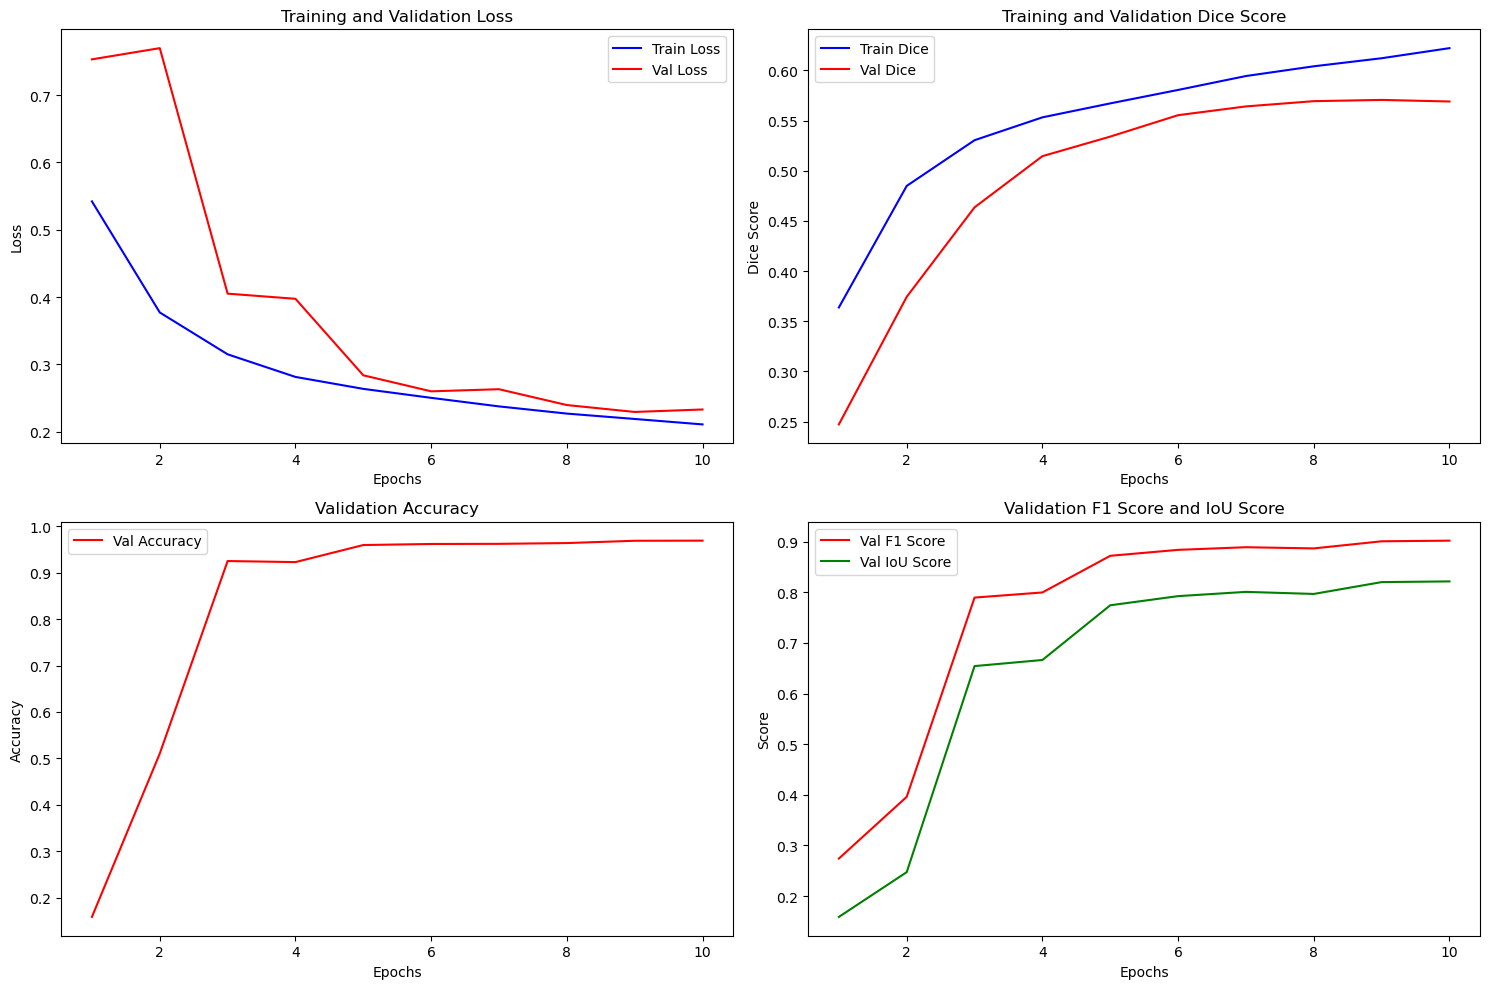

In [25]:
def plot_metrics(results):
    epochs = range(1, len(results['train_loss']) + 1)

    plt.figure(figsize=(15, 10))

    # Plot Loss
    plt.subplot(2, 2, 1)
    plt.plot(epochs, results['train_loss'], 'b', label='Train Loss')
    plt.plot(epochs, results['val_loss'], 'r', label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Dice Score
    plt.subplot(2, 2, 2)
    plt.plot(epochs, results['train_dice'], 'b', label='Train Dice')
    plt.plot(epochs, results['val_dice'], 'r', label='Val Dice')
    plt.title('Training and Validation Dice Score')
    plt.xlabel('Epochs')
    plt.ylabel('Dice Score')
    plt.legend()

    # Plot Accuracy
    plt.subplot(2, 2, 3)
    plt.plot(epochs, results['val_accuracy'], 'r', label='Val Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot F1-Score and IoU Score
    plt.subplot(2, 2, 4)
    plt.plot(epochs, results['val_f1'], 'r', label='Val F1 Score')
    plt.plot(epochs, results['val_iou'], 'g', label='Val IoU Score')
    plt.title('Validation F1 Score and IoU Score')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot results
plot_metrics(results)


# def eval_metrics(results):
#     # Plotting
#     epochs = range(1, len(results['train_loss']) + 1)
#     plt.figure(figsize=(10, 5))
    
#     # Plot BCE Loss
#     plt.subplot(1, 2, 1)
#     plt.plot(epochs, results['train_loss'], 'b', label = 'Train BCE Loss')
#     plt.plot(epochs, results['val_loss'], 'r', label = 'Val BCE Loss')
#     # plt.plot(epochs, results['train_iou_loss'], 'g', label = 'Train IoU Loss')
#     # plt.plot(epochs, results['val_iou_loss'], 'y', label = 'Val IoU Loss')
#     plt.title('Training and Validation Loss')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.legend()

#     # Plot Dice Scores
#     plt.subplot(1, 2, 2)
#     plt.plot(epochs, results['train_dice'], 'b', label = 'Train Dice Score')
#     plt.plot(epochs, results['val_dice'], 'r', label = 'Val Dice Score')
#     # plt.plot(epochs, results['train_iou_dice'], 'g', label = 'Train Dice Score (using IoU Loss)')
#     # plt.plot(epochs, results['val_iou_dice'], 'y', label = 'Val Dice Score (using IoU Loss)')
#     plt.title('Training and Validation Dice Scores')
#     plt.xlabel('Epochs')
#     plt.ylabel('Dice Score')
#     plt.legend()

#     plt.tight_layout()
#     plt.show()

#     # Confusion Matrix for Final Validation Set
#     print("Displaying the Confusion Matrix (Post-Training):")
#     with torch.no_grad():
#         for val_input, val_mask in val_dataloader:
#             val_input = val_input.to(DEVICE)
#             val_mask = val_mask.to(DEVICE)
            
#             # Forward pass to get predictions
#             outputs = model(val_input.float())
            
#             # Plot confusion matrix for the final validation set
#             plot_confusion_matrix(outputs, val_mask)
#             break  # Only show the confusion matrix for one batch (adjust if needed)

# # Calling the Evaluation Metric Function
# eval_metrics(results)

**Saving the Model**

In [17]:
# # To save the Model with additional training data
# # UNet Model
# torch.save({
#     'model_state_dict': model.state_dict(),
#     'epoch': epoch,
#     'optimizer_state_dict': optimizer.state_dict(),
#     'results': results
# }, 'unet_kitti.ckpt')

# # Modified VGG Model
# torch.save({
#     'model_state_dict': model.state_dict(),
#     'epoch': epoch,
#     'optimizer_state_dict': optimizer.state_dict(),
#     'results': results
# }, 'modified_vgg_kitti.ckpt')

# To only save the Model
torch.save(model.state_dict(), 'unet_kitti.pth')            # UNet Model 
# torch.save(model.state_dict(), 'modified_vgg_kitti.pth')    # Modified VGG Model

**Confusion Matrix**

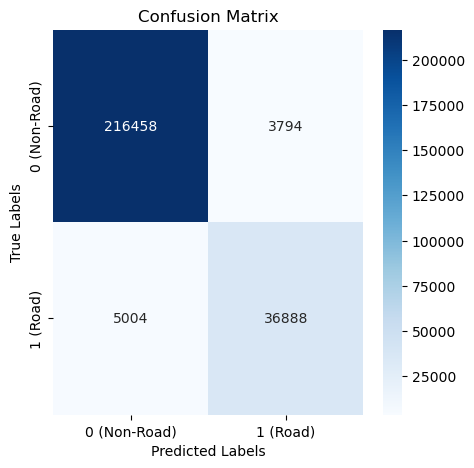

Final F1-Score: 0.8935, Final IoU: 0.8074, Final Accuracy: 0.9664


In [18]:
# Confusion Matrix
def plot_confusion_matrix(pred, target):

    # Binarize the predicted and true masks
    pred = torch.sigmoid(pred) > 0.5  # Binary threshold to create binary mask (0 or 1)
    pred = pred.contiguous().view(-1).cpu().numpy()  # Flatten the prediction
    target = target.contiguous().view(-1).cpu().numpy()  # Flatten the target mask

    # Compute confusion matrix
    cm = confusion_matrix(target, pred)

    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["0 (Non-Road)", "1 (Road)"], yticklabels=["0 (Non-Road)", "1 (Road)"])
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

# Final Evaluation on Validation Set
with torch.no_grad():
    for val_input, val_mask in val_dataloader:
        val_input = val_input.to(DEVICE)
        val_mask = val_mask.to(DEVICE)
        
        outputs = model(val_input.float())
        
        # Plot Confusion Matrix
        plot_confusion_matrix(outputs, val_mask)

        # Calculate and print final metrics
        final_f1 = f1_metric(outputs, val_mask).item()
        final_iou = iou_metric(outputs, val_mask).item()
        final_accuracy = accuracy_metric(outputs, val_mask).item()
        print(f"Final F1-Score: {final_f1:.4f}, Final IoU: {final_iou:.4f}, Final Accuracy: {final_accuracy:.4f}")
        break  # Run for one batch

**Loading the Model**

In [19]:
# # Loading the UNET Model
# checkpoint = torch.load("/DML/Models/unet_kitti.ckpt")
# model.load_state_dict(checkpoint["model_state_dict"])

# # Loading the Modified VGG Model
# checkpoint = torch.load("/DML/Models/modified_vgg_kitti.ckpt")
# model.load_state_dict(checkpoint["model_state_dict"])

# Loading the Model
model.load_state_dict(torch.load('unet_kitti.pth'))
# model.load_state_dict(torch.load('/DML/Models/modified_vgg_kitti.pth'))

<All keys matched successfully>

**Evaluation on Test Set**

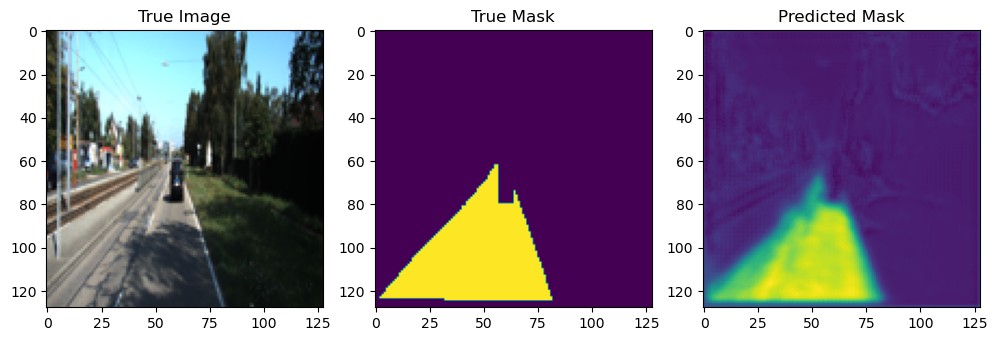

In [20]:
def get_predicted_masks(model, data_loader, loss_fn, device):
    model.eval()
    all_masks = []
    total_loss = 0.0
    num_batches = 0
    
    with torch.no_grad():
        for test_input, test_mask in data_loader:
            test_input, test_mask = test_input.to(device), test_mask.to(device)
            
            # Forward pass
            outputs = model(test_input.float())

            # Compute loss
            loss = loss_fn(outputs.float(), test_mask.float())
            total_loss += loss.item()
            num_batches += 1

            # Store masks (detach, move to CPU, convert to numpy)
            predicted_masks = outputs.cpu().numpy()
            all_masks.append(predicted_masks)

    avg_loss = total_loss / num_batches
    return avg_loss, np.vstack(all_masks)  # Stack all masks to return as a single array

# Running the function on test data
loss, predicted_masks = get_predicted_masks(model, test_dataloader, loss_fn, DEVICE)

# Testing Phase: Visualize prediction vs true mask
test_idx = 30  # Index of the test image

fig, ax = plt.subplots(1, 3, figsize=(10, 5))

# True Image
ax[0].imshow(X_test[test_idx].transpose(1, 2, 0))
ax[0].set_title("True Image")

# True Mask
ax[1].imshow(Y_test[test_idx].transpose(1, 2, 0))
ax[1].set_title("True Mask")

# Predicted Mask
ax[2].imshow(predicted_masks[test_idx].transpose(1, 2, 0))
ax[2].set_title("Predicted Mask")

plt.tight_layout()
plt.show()

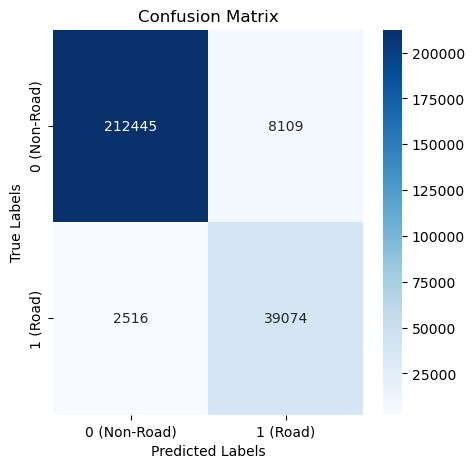

Final F1-Score: 0.8803, Final IoU: 0.7862, Final Accuracy: 0.9595


In [21]:
# On Test Data
# Confusion Matrix and Test Results
with torch.no_grad():
    for test_input, test_mask in test_dataloader:
        test_input = test_input.to(DEVICE)
        test_mask = test_mask.to(DEVICE)
        
        test_outputs = model(test_input.float())
        
        # Plot Confusion Matrix
        plot_confusion_matrix(test_outputs, test_mask)

        # Calculate and print final metrics
        test_f1 = f1_metric(test_outputs, test_mask).item()
        test_iou = iou_metric(test_outputs, test_mask).item()
        test_accuracy = accuracy_metric(test_outputs, test_mask).item()
        print(f"Final F1-Score: {test_f1:.4f}, Final IoU: {test_iou:.4f}, Final Accuracy: {test_accuracy:.4f}")
        break  # Run for one batch

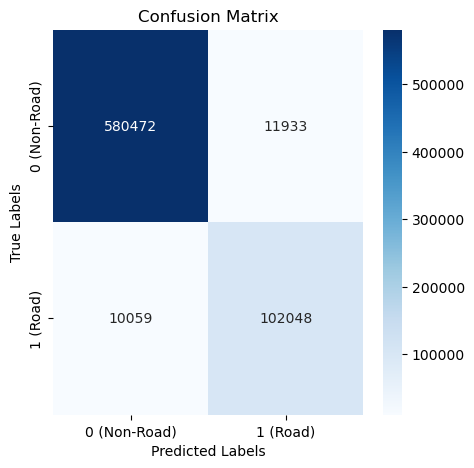

Final F1-Score: 0.9027, Final IoU: 0.8227, Final Accuracy: 0.9688


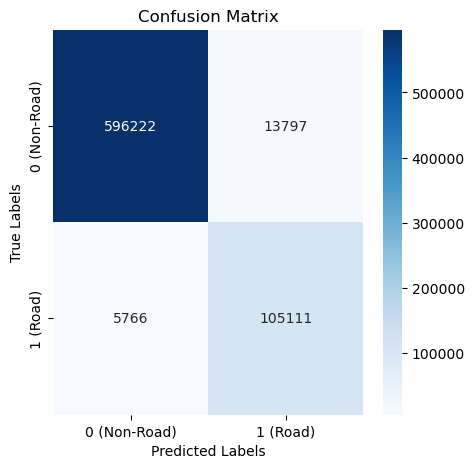

Final F1-Score: 0.9149, Final IoU: 0.8431, Final Accuracy: 0.9729


In [22]:


# Confusion Matrix Function
def plot_confusion_matrix(pred, target):
    # Binarize the predicted and true masks
    pred = torch.sigmoid(pred) > 0.5  # Apply thresholding to get binary predictions
    pred = pred.contiguous().view(-1).cpu().numpy()  # Flatten the prediction
    target = target.contiguous().view(-1).cpu().numpy()  # Flatten the target mask

    # Compute confusion matrix
    cm = confusion_matrix(target, pred)

    # Plot confusion matrix
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["0 (Non-Road)", "1 (Road)"], yticklabels=["0 (Non-Road)", "1 (Road)"])
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

# Corrected Evaluation Loop for Validation/Test
def evaluate_model_with_cm(model, dataloader, f1_metric, iou_metric, accuracy_metric, device):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data_input, data_mask in dataloader:
            data_input, data_mask = data_input.to(device), data_mask.to(device)
            
            # Get model predictions
            outputs = model(data_input.float())
            
            # Apply sigmoid and threshold to get binary predictions
            preds = torch.sigmoid(outputs) > 0.5
            
            # Flatten predictions and targets and collect across all batches
            all_preds.append(preds.contiguous().view(-1).cpu().numpy())
            all_targets.append(data_mask.contiguous().view(-1).cpu().numpy())

    # Concatenate all batches for full dataset confusion matrix
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    # Plot confusion matrix on the full dataset
    plot_confusion_matrix(torch.tensor(all_preds), torch.tensor(all_targets))

    # Calculate final metrics (F1, IoU, Accuracy)
    final_f1 = f1_score(all_targets, all_preds, average='binary')
    final_iou = jaccard_score(all_targets, all_preds, average='binary')
    final_accuracy = (all_preds == all_targets).sum() / all_targets.size

    print(f"Final F1-Score: {final_f1:.4f}, Final IoU: {final_iou:.4f}, Final Accuracy: {final_accuracy:.4f}")

# Final Evaluation on Validation Set
with torch.no_grad():
    evaluate_model_with_cm(model, val_dataloader, f1_metric, iou_metric, accuracy_metric, DEVICE)

# Final Evaluation on Test Set
with torch.no_grad():
    evaluate_model_with_cm(model, test_dataloader, f1_metric, iou_metric, accuracy_metric, DEVICE)


In [23]:
# Final Evaluation phase for validation/test dataset
def evaluate_model(model, dataloader, loss_fn, device, epoch=None):
    model.eval()  # Set to evaluation mode
    eval_loss = 0
    total_correct_eval = 0
    total_pixels_eval = 0
    all_preds = []
    all_masks = []
    f1_scores = []
    jaccard_indices = []
    confusion_matrices = []

    with torch.no_grad():
        for index, (eval_input, eval_mask) in enumerate(dataloader):
            eval_input, eval_mask = eval_input.to(device), eval_mask.to(device)
            if epoch is not None:
                print(f"Now evaluating batch {index} epoch {epoch}.")
            
            # Forward pass
            eval_output = model(eval_input)
            eval_loss += loss_fn(eval_output, eval_mask).item()

            # Binarize the predictions
            preds = torch.sigmoid(eval_output) > 0.5
            
            # Calculate the total number of correct pixels and total pixels
            total_correct_eval += (preds == eval_mask.byte()).sum().item()
            total_pixels_eval += eval_mask.numel()

            # Collect predictions and masks for metrics calculations
            all_preds.append(preds.cpu().numpy().flatten())
            all_masks.append(eval_mask.cpu().numpy().flatten())

        # After the loop, concatenate all predictions and masks
        all_preds = np.concatenate(all_preds)
        all_masks = np.concatenate(all_masks)

        # Calculate F1-Score and IoU (Jaccard Index) using sklearn
        f1 = f1_score(all_masks, all_preds, average='binary')
        jaccard = jaccard_score(all_masks, all_preds, average='binary')

        f1_scores.append(f1)
        jaccard_indices.append(jaccard)

        # Print the F1-Score and IoU
        print(f"F1-Score: {f1:.4f}, Jaccard Index (IoU): {jaccard:.4f}")

        # Confusion Matrix
        conf_matrix = confusion_matrix(all_masks, all_preds)
        confusion_matrices.append(conf_matrix)

        # Print Confusion Matrix
        if epoch is not None:
            print(f"Confusion Matrix at Epoch {epoch + 1}:")
        else:
            print(f"Confusion Matrix:")
        print(conf_matrix)

    return eval_loss / len(dataloader), f1_scores, jaccard_indices, confusion_matrices

# Example usage:
# Evaluate on the validation set
val_loss, val_f1_scores, val_jaccard_indices, val_confusion_matrices = evaluate_model(
    model=model, 
    dataloader=val_dataloader, 
    loss_fn=loss_fn, 
    device=DEVICE, 
    epoch=0
)

# Evaluate on the test set
test_loss, test_f1_scores, test_jaccard_indices, test_confusion_matrices = evaluate_model(
    model=model, 
    dataloader=test_dataloader, 
    loss_fn=loss_fn, 
    device=DEVICE
)


Now evaluating batch 0 epoch 0.
Now evaluating batch 1 epoch 0.
Now evaluating batch 2 epoch 0.
F1-Score: 0.9027, Jaccard Index (IoU): 0.8227
Confusion Matrix at Epoch 1:
[[580472  11933]
 [ 10059 102048]]
F1-Score: 0.9149, Jaccard Index (IoU): 0.8431
Confusion Matrix:
[[596222  13797]
 [  5766 105111]]
